# Changelog

## Version 20

* Tuning LightGBM parameter from version 18 result
* Stop using validation data

## Version 18

* Tuning LightGBM parameter from version 16 result
    * num_leaves : 63
    * min_data_in_leaf : 20, 50
    * bagging_fraction : **no diff**
    * feature_fraction : 0.9, 1.0
    * max_bin : 16, 102, 255
    * min_data_per_group : 1
* Use validation data to reduce overfit

## Version 16

* Tuning LightGBM parameter from version 15 result
    * boosting_type : gbdt
    * n_estimators : 100
    * LR : 0.01
    * num_leaves : 31, 63
    * min_data_in_leaf : 20, 50

## Version 15

* Make submission for all mode
* Fix dump `df_model`
* Remove `age` from category feature

## Version 13

* Tuning LightGBM parameter
* Add additional preprocessing
* Add EDA

## Version 10

* Add additional preprocessing

## Version 9

* Use StratifiedKFold 3, 5, 10
* Combine parameter from verison 4 & 5
* Use mean and mode to predict data

## Version 5

* Use MCC score
* Visualize LightGBM tree
* Use different processed dataset
* Specify categorical feature
* Tweak parameter

## Version 4

* Attempt fix overfit
* Tweak class weight

## Version 2

* Fix wrong row
* Lower `max_bin` 255 -> 64
* Increase `num_iterations` 5000 -> 10000

## Version 1

* Initial Code

# Library

In [1]:
import os
import random
import platform
import itertools

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import lightgbm as lgbm
import scipy

In [2]:
!pip freeze > requirements.txt

In [3]:
print('Python version:', platform.python_version())
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Matplotlib version:', matplotlib.__version__)
print('Seaborn version:', sns.__version__)
print('Scikit-Learn version:', sklearn.__version__)
print('LightGBM version:', lgbm.__version__)
print('Scipy version:', scipy.__version__)

Python version: 3.7.6
Numpy version: 1.18.5
Pandas version: 1.0.3
Matplotlib version: 3.2.1
Seaborn version: 0.10.0
Scikit-Learn version: 0.23.1
LightGBM version: 2.3.1
Scipy version: 1.4.1


In [4]:
SEED = 42

os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [5]:
pd.set_option('display.width', None)
pd.set_option('display.max_column', None)

# Processed Dataset

In [6]:
df_train = pd.read_parquet('/kaggle/input/shopee-marketing-data/train_processed.parquet')
df_train

,country_code,grass_date,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,attr_1,attr_2,attr_3,age,domain
0,4,2019-07-16 00:00:00+08:00,44,19.0,6.0,18.0,0,2,4,12,43,99,0,5,10,0,1.0,1.0,2.0,47.0,0.0
1,4,2019-07-16 00:00:00+08:00,44,9.0,4.0,8.0,2,9,17,18,48,90,1,1,4,1,1.0,1.0,2.0,25.0,3.0
2,6,2019-07-16 00:00:00+08:00,49,14.0,5.0,5.0,0,4,12,24,69,119,5,19,27,0,NaN,1.0,0.0,NaN,2.0
3,1,2019-07-16 00:00:00+08:00,49,49.0,9.0,53.0,0,0,1,9,23,69,1,3,6,0,1.0,1.0,2.0,24.0,2.0
4,6,2019-07-16 00:00:00+08:00,49,227.0,6.0,221.0,0,0,0,2,5,5,0,0,0,0,NaN,1.0,0.0,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73534,6,2019-09-02 00:00:00+08:00,39,24.0,36.0,279.0,0,1,1,0,0,0,0,0,0,0,1.0,1.0,1.0,37.0,0.0
73535,2,2019-09-02 00:00:00+08:00,38,46.0,10.0,51.0,0,0,1,0,0,0,0,0,0,0,NaN,1.0,0.0,NaN,0.0
73536,2,2019-09-02 00:00:00+08:00,32,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,NaN,1.0,0.0,NaN,9.0
73537,2,2019-09-02 00:00:00+08:00,38,5.0,34.0,NaN,2,4,4,0,0,0,0,0,0,1,NaN,1.0,0.0,NaN,0.0


In [7]:
df_test = pd.read_parquet('/kaggle/input/shopee-marketing-data/test_processed.parquet')
df_test

,country_code,grass_date,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,attr_1,attr_2,attr_3,age,domain
0,6,2019-09-03 00:00:00+08:00,35,27.0,2.0,13.0,2,3,4,10,34,134,0,6,18,NaN,1.0,0.0,NaN,0.0
1,6,2019-09-03 00:00:00+08:00,35,7.0,5.0,383.0,1,1,1,5,5,5,0,0,0,NaN,1.0,0.0,NaN,0.0
2,5,2019-09-03 00:00:00+08:00,25,34.0,1.0,3.0,0,0,0,13,19,38,2,2,2,1.0,1.0,2.0,33.0,0.0
3,1,2019-09-03 00:00:00+08:00,36,63.0,5.0,5.0,0,0,0,43,110,173,2,5,5,1.0,1.0,2.0,22.0,2.0
4,5,2019-09-03 00:00:00+08:00,23,6.0,5.0,54.0,0,0,0,4,12,39,0,0,2,NaN,1.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,2019-09-29 00:00:00+08:00,53,NaN,4.0,8.0,0,0,0,0,0,0,0,0,0,NaN,1.0,0.0,NaN,3.0
55966,6,2019-09-29 00:00:00+08:00,53,59.0,802.0,1207.0,0,0,1,0,0,0,0,0,0,NaN,1.0,0.0,NaN,0.0
55967,6,2019-09-29 00:00:00+08:00,43,NaN,7.0,NaN,0,0,0,0,0,0,0,0,0,NaN,1.0,0.0,NaN,0.0
55968,6,2019-09-29 00:00:00+08:00,43,5.0,5.0,6.0,2,5,14,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN


# EDA

In [8]:
df_train.describe()

,country_code,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,attr_1,attr_2,attr_3,age,domain
count,73539.000000,73539.000000,66021.00000,73260.000000,56634.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,45758.000000,73287.000000,73518.000000,45758.000000,73518.000000
mean,2.533159,43.656373,32.75323,53.335695,73.645725,0.911829,2.780457,5.019364,8.382287,25.284053,49.010430,0.909898,2.796040,5.420960,0.155781,0.999847,0.997912,1.087230,31.348464,0.434166
std,1.675251,11.219323,55.16675,345.223999,129.415239,1.754052,4.570239,7.902313,13.424436,37.853189,71.819327,2.887416,7.686064,13.980182,0.362650,0.012368,0.045644,1.033832,11.584066,1.259629
min,1.000000,10.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-16.000000,0.000000
25%,1.000000,34.000000,5.00000,3.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,24.000000,0.000000
50%,2.000000,43.000000,14.00000,8.000000,22.000000,0.000000,1.000000,2.000000,3.000000,11.000000,22.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,29.000000,0.000000
75%,3.000000,52.000000,38.00000,26.000000,77.000000,1.000000,3.000000,6.000000,12.000000,35.000000,69.000000,1.000000,3.000000,6.000000,0.000000,1.000000,1.000000,2.000000,36.000000,0.000000
max,7.000000,75.000000,808.00000,18141.000000,1445.000000,31.000000,92.000000,135.000000,254.000000,735.000000,1260.000000,157.000000,531.000000,783.000000,1.000000,1.000000,1.000000,4.000000,118.000000,10.000000


In [9]:
df_test.describe()

,country_code,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,attr_1,attr_2,attr_3,age,domain
count,55970.000000,55970.000000,48381.000000,55801.000000,44567.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,34254.000000,55731.000000,55951.000000,34254.000000,55951.000000
mean,2.835215,42.212703,32.641078,47.723607,69.409743,0.774272,2.441880,5.323530,8.978899,26.289459,50.713882,1.124674,3.219385,5.933893,0.999796,0.998152,1.070347,31.404099,0.444407
std,1.728489,12.276136,52.263247,276.075845,126.579497,1.752984,4.786883,9.053473,13.975840,38.572656,73.289199,3.500704,8.197445,14.233715,0.014294,0.042951,1.036071,11.609694,1.298730
min,1.000000,11.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.000000,0.000000
25%,1.000000,35.000000,6.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,24.000000,0.000000
50%,3.000000,41.000000,18.000000,8.000000,19.000000,0.000000,0.000000,2.000000,4.000000,13.000000,25.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,29.000000,0.000000
75%,4.000000,48.000000,40.000000,23.000000,69.000000,1.000000,3.000000,6.000000,13.000000,36.000000,70.000000,1.000000,3.000000,7.000000,1.000000,1.000000,2.000000,36.000000,0.000000
max,7.000000,79.000000,812.000000,18165.000000,1462.000000,30.000000,79.000000,120.000000,329.000000,746.000000,1300.000000,252.000000,404.000000,609.000000,1.000000,1.000000,4.000000,118.000000,10.000000


In [10]:
df_train.isnull().sum()

country_code                       0
grass_date                         0
subject_line_length                0
last_open_day                   7518
last_login_day                   279
last_checkout_day              16905
open_count_last_10_days            0
open_count_last_30_days            0
open_count_last_60_days            0
login_count_last_10_days           0
login_count_last_30_days           0
login_count_last_60_days           0
checkout_count_last_10_days        0
checkout_count_last_30_days        0
checkout_count_last_60_days        0
open_flag                          0
attr_1                         27781
attr_2                           252
attr_3                            21
age                            27781
domain                            21
dtype: int64

In [11]:
df_test.isnull().sum()

country_code                       0
grass_date                         0
subject_line_length                0
last_open_day                   7589
last_login_day                   169
last_checkout_day              11403
open_count_last_10_days            0
open_count_last_30_days            0
open_count_last_60_days            0
login_count_last_10_days           0
login_count_last_30_days           0
login_count_last_60_days           0
checkout_count_last_10_days        0
checkout_count_last_30_days        0
checkout_count_last_60_days        0
attr_1                         21716
attr_2                           239
attr_3                            19
age                            21716
domain                            19
dtype: int64

## Age

In [12]:
print('Train dataset!')
print('Total data with age below 13:', df_train['age'][df_train['age'] < 13].count())
print('Total data with age below 18:', df_train['age'][df_train['age'] < 18].count())
print('Total data with age 70 or more:', df_train['age'][df_train['age'] >= 70].count())
print('Total data with age 100 or more:', df_train['age'][df_train['age'] >= 100].count())

print('Test dataset!')
print('Total data with age below 13:', df_test['age'][df_test['age'] < 13].count())
print('Total data with age below 18:', df_test['age'][df_test['age'] < 18].count())
print('Total data with age 70 or more:', df_test['age'][df_test['age'] >= 70].count())
print('Total data with age 100 or more:', df_test['age'][df_test['age'] >= 100].count())

Train dataset!
Total data with age below 13: 326
Total data with age below 18: 962
Total data with age 70 or more: 343
Total data with age 100 or more: 286
Test dataset!
Total data with age below 13: 215
Total data with age below 18: 758
Total data with age 70 or more: 253
Total data with age 100 or more: 217


## last_login_day & last_checkout_day

In [13]:
df_train[ df_train['last_login_day'].isnull() & ~df_train['last_checkout_day'].isnull() ]

,country_code,grass_date,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,attr_1,attr_2,attr_3,age,domain
7022,1,2019-07-21 00:00:00+08:00,40,NaN,NaN,66.0,0,0,0,37,92,122,0,0,0,0,1.0,1.0,4.0,43.0,3.0
12170,4,2019-07-24 00:00:00+08:00,53,NaN,NaN,43.0,0,0,0,1,2,7,0,0,1,0,1.0,NaN,2.0,28.0,2.0
12173,4,2019-07-24 00:00:00+08:00,53,NaN,NaN,443.0,0,0,0,0,1,6,0,0,0,0,1.0,NaN,2.0,29.0,0.0
12175,4,2019-07-24 00:00:00+08:00,53,NaN,NaN,5.0,0,0,0,18,47,93,3,13,18,0,1.0,NaN,2.0,27.0,2.0
12177,4,2019-07-24 00:00:00+08:00,53,NaN,NaN,1.0,2,2,3,9,29,62,4,11,17,1,1.0,NaN,2.0,22.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42788,4,2019-08-14 00:00:00+08:00,33,NaN,NaN,101.0,1,1,1,42,142,289,0,0,0,0,1.0,1.0,1.0,31.0,0.0
50177,7,2019-08-19 00:00:00+08:00,69,NaN,NaN,73.0,0,0,0,0,3,18,0,0,0,0,1.0,1.0,2.0,31.0,0.0
52770,1,2019-08-20 00:00:00+08:00,68,NaN,NaN,14.0,0,0,1,52,153,277,0,2,3,0,1.0,1.0,1.0,25.0,0.0
54478,3,2019-08-21 00:00:00+08:00,23,NaN,NaN,55.0,0,4,7,0,0,15,0,0,1,0,NaN,1.0,0.0,NaN,0.0


In [14]:
df_test[ df_test['last_login_day'].isnull() & ~df_test['last_checkout_day'].isnull() ]

,country_code,grass_date,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,attr_1,attr_2,attr_3,age,domain
20896,3,2019-09-09 00:00:00+08:00,41,NaN,NaN,3.0,0,0,1,8,28,48,3,7,11,1.0,1.0,1.0,36.0,2.0
38884,6,2019-09-16 00:00:00+08:00,20,NaN,NaN,16.0,1,2,6,54,151,309,0,0,0,NaN,1.0,0.0,NaN,0.0
48025,6,2019-09-23 00:00:00+08:00,30,NaN,NaN,3.0,0,0,2,0,0,0,0,0,0,1.0,1.0,2.0,29.0,2.0
49559,6,2019-09-24 00:00:00+08:00,20,NaN,NaN,54.0,0,0,0,17,82,225,0,0,1,1.0,1.0,2.0,19.0,0.0
51541,6,2019-09-25 00:00:00+08:00,54,NaN,NaN,36.0,1,4,6,0,0,0,0,0,0,1.0,0.0,1.0,26.0,0.0


## last_open_day && open_count_last_{}_days

In [15]:
df_train[ df_train['last_open_day'].isnull() & ((df_train['open_count_last_10_days'] > 0) | (df_train['open_count_last_30_days'] > 0) | (df_train['open_count_last_60_days'] > 0)) ]

,country_code,grass_date,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,attr_1,attr_2,attr_3,age,domain
667,1,2019-07-16 00:00:00+08:00,58,NaN,14.0,19.0,1,1,1,0,15,18,0,1,1,0,NaN,1.0,0.0,NaN,0.0
1011,2,2019-07-16 00:00:00+08:00,36,NaN,196.0,45.0,0,2,2,0,0,2,0,0,4,0,1.0,1.0,1.0,29.0,0.0
1132,2,2019-07-16 00:00:00+08:00,36,NaN,15.0,15.0,1,1,1,0,0,0,0,0,0,1,1.0,1.0,2.0,27.0,0.0
1287,5,2019-07-16 00:00:00+08:00,43,NaN,94.0,197.0,2,2,2,0,0,0,0,0,0,0,1.0,1.0,2.0,31.0,0.0
1321,2,2019-07-16 00:00:00+08:00,36,NaN,348.0,NaN,0,2,2,0,0,0,0,0,0,0,1.0,1.0,2.0,27.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73228,1,2019-09-02 00:00:00+08:00,33,NaN,27.0,NaN,2,2,2,0,2,2,0,0,0,1,NaN,1.0,0.0,NaN,0.0
73269,1,2019-09-02 00:00:00+08:00,33,NaN,27.0,NaN,2,2,2,0,1,1,0,0,0,0,NaN,1.0,0.0,NaN,0.0
73363,1,2019-09-02 00:00:00+08:00,33,NaN,14.0,NaN,0,1,1,0,5,5,0,0,0,0,NaN,1.0,0.0,NaN,0.0
73415,3,2019-09-02 00:00:00+08:00,49,NaN,3.0,NaN,1,1,1,8,17,17,0,0,0,0,1.0,1.0,1.0,1.0,0.0


In [16]:
df_test[ df_test['last_open_day'].isnull() & ((df_test['open_count_last_10_days'] > 0) | (df_test['open_count_last_30_days'] > 0) | (df_test['open_count_last_60_days'] > 0)) ]

,country_code,grass_date,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,attr_1,attr_2,attr_3,age,domain
3080,1,2019-09-03 00:00:00+08:00,36,NaN,2.0,2.0,0,1,1,42,77,77,11,13,13,1.0,1.0,1.0,20.0,0.0
3085,6,2019-09-03 00:00:00+08:00,35,NaN,1.0,7.0,1,1,1,4,5,5,2,2,2,1.0,1.0,2.0,22.0,0.0
3106,1,2019-09-03 00:00:00+08:00,43,NaN,13.0,NaN,1,1,1,1,17,17,0,0,0,NaN,1.0,0.0,NaN,0.0
3133,1,2019-09-03 00:00:00+08:00,43,NaN,11.0,26.0,2,2,2,3,21,21,0,1,1,NaN,1.0,0.0,NaN,0.0
3215,1,2019-09-03 00:00:00+08:00,43,NaN,11.0,14.0,1,1,1,2,10,10,0,3,3,1.0,1.0,2.0,31.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54302,6,2019-09-27 00:00:00+08:00,21,NaN,NaN,NaN,3,7,8,0,0,0,0,0,0,1.0,1.0,1.0,29.0,0.0
55202,3,2019-09-28 00:00:00+08:00,38,NaN,2.0,4.0,1,1,1,37,56,56,1,2,2,NaN,1.0,0.0,NaN,0.0
55916,3,2019-09-29 00:00:00+08:00,50,NaN,15.0,NaN,3,6,6,0,6,6,0,0,0,NaN,1.0,0.0,NaN,0.0
55924,3,2019-09-29 00:00:00+08:00,43,NaN,5.0,NaN,2,2,2,1,8,8,0,0,0,1.0,1.0,3.0,30.0,0.0


## last_login_day && login_count_last_{}_days

In [17]:
df_train[ df_train['last_login_day'].isnull() & ((df_train['login_count_last_10_days'] > 0) | (df_train['login_count_last_30_days'] > 0) | (df_train['login_count_last_60_days'] > 0)) ]

,country_code,grass_date,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,attr_1,attr_2,attr_3,age,domain
7022,1,2019-07-21 00:00:00+08:00,40,NaN,NaN,66.0,0,0,0,37,92,122,0,0,0,0,1.0,1.0,4.0,43.0,3.0
11759,3,2019-07-23 00:00:00+08:00,47,NaN,NaN,NaN,0,0,0,0,0,2,0,0,0,1,NaN,1.0,0.0,NaN,2.0
12170,4,2019-07-24 00:00:00+08:00,53,NaN,NaN,43.0,0,0,0,1,2,7,0,0,1,0,1.0,NaN,2.0,28.0,2.0
12173,4,2019-07-24 00:00:00+08:00,53,NaN,NaN,443.0,0,0,0,0,1,6,0,0,0,0,1.0,NaN,2.0,29.0,0.0
12175,4,2019-07-24 00:00:00+08:00,53,NaN,NaN,5.0,0,0,0,18,47,93,3,13,18,0,1.0,NaN,2.0,27.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50177,7,2019-08-19 00:00:00+08:00,69,NaN,NaN,73.0,0,0,0,0,3,18,0,0,0,0,1.0,1.0,2.0,31.0,0.0
52770,1,2019-08-20 00:00:00+08:00,68,NaN,NaN,14.0,0,0,1,52,153,277,0,2,3,0,1.0,1.0,1.0,25.0,0.0
53971,2,2019-08-21 00:00:00+08:00,38,NaN,NaN,NaN,0,1,6,2,17,25,0,17,18,0,NaN,1.0,0.0,NaN,0.0
54478,3,2019-08-21 00:00:00+08:00,23,NaN,NaN,55.0,0,4,7,0,0,15,0,0,1,0,NaN,1.0,0.0,NaN,0.0


In [18]:
df_test[ df_test['last_login_day'].isnull() & ((df_test['login_count_last_10_days'] > 0) | (df_test['login_count_last_30_days'] > 0) | (df_test['login_count_last_60_days'] > 0)) ]

,country_code,grass_date,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,attr_1,attr_2,attr_3,age,domain
20896,3,2019-09-09 00:00:00+08:00,41,NaN,NaN,3.0,0,0,1,8,28,48,3,7,11,1.0,1.0,1.0,36.0,2.0
30797,6,2019-09-11 00:00:00+08:00,20,NaN,NaN,NaN,0,0,0,1,1,1,0,0,0,1.0,1.0,1.0,33.0,0.0
31043,6,2019-09-11 00:00:00+08:00,20,NaN,NaN,NaN,0,0,0,13,41,76,0,0,0,NaN,1.0,0.0,NaN,0.0
31332,6,2019-09-11 00:00:00+08:00,20,NaN,NaN,NaN,0,0,0,0,1,2,0,0,0,1.0,1.0,1.0,22.0,0.0
31765,6,2019-09-11 00:00:00+08:00,20,NaN,NaN,NaN,0,0,1,21,69,142,0,0,0,NaN,1.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54095,6,2019-09-27 00:00:00+08:00,21,NaN,NaN,NaN,0,1,3,13,40,93,0,0,0,1.0,1.0,2.0,22.0,3.0
54147,6,2019-09-27 00:00:00+08:00,21,NaN,NaN,NaN,1,2,7,5,23,57,0,0,0,NaN,1.0,0.0,NaN,3.0
54155,6,2019-09-27 00:00:00+08:00,21,NaN,NaN,NaN,0,0,0,0,0,7,0,0,0,NaN,1.0,0.0,NaN,9.0
54293,6,2019-09-27 00:00:00+08:00,21,NaN,NaN,NaN,2,2,2,13,13,13,0,0,0,1.0,1.0,1.0,29.0,0.0


## last_login_day && login_count_last_{}_days

In [19]:
df_train[ df_train['last_checkout_day'].isnull() & ((df_train['checkout_count_last_10_days'] > 0) | (df_train['checkout_count_last_30_days'] > 0) | (df_train['checkout_count_last_60_days'] > 0)) ]

,country_code,grass_date,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,attr_1,attr_2,attr_3,age,domain
405,1,2019-07-16 00:00:00+08:00,58,4.0,38.0,NaN,6,15,29,4,25,52,0,0,3,0,1.0,1.0,2.0,24.0,0.0
688,1,2019-07-16 00:00:00+08:00,64,83.0,4.0,NaN,0,0,0,35,126,273,0,3,14,0,1.0,1.0,1.0,33.0,0.0
705,2,2019-07-16 00:00:00+08:00,36,3.0,95.0,NaN,11,18,23,1,8,54,0,0,7,1,NaN,1.0,0.0,NaN,0.0
738,3,2019-07-16 00:00:00+08:00,33,7.0,37.0,NaN,1,5,10,1,1,6,0,0,1,0,1.0,1.0,2.0,27.0,0.0
841,1,2019-07-16 00:00:00+08:00,49,22.0,6.0,NaN,0,1,2,7,19,48,2,10,24,0,1.0,1.0,2.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73371,1,2019-09-02 00:00:00+08:00,33,NaN,14.0,NaN,0,0,0,1,7,7,0,2,2,0,NaN,1.0,0.0,NaN,0.0
73412,1,2019-09-02 00:00:00+08:00,33,NaN,2.0,NaN,0,0,0,17,29,29,0,1,1,0,NaN,1.0,0.0,NaN,0.0
73449,2,2019-09-02 00:00:00+08:00,38,14.0,2.0,NaN,0,0,0,7,20,20,0,1,1,0,1.0,1.0,1.0,29.0,0.0
73454,1,2019-09-02 00:00:00+08:00,33,13.0,1.0,NaN,0,0,0,11,20,20,26,49,49,0,1.0,1.0,2.0,50.0,2.0


In [20]:
df_test[ df_test['last_checkout_day'].isnull() & ((df_test['checkout_count_last_10_days'] > 0) | (df_test['checkout_count_last_30_days'] > 0) | (df_test['checkout_count_last_60_days'] > 0)) ]

,country_code,grass_date,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,attr_1,attr_2,attr_3,age,domain
863,1,2019-09-03 00:00:00+08:00,43,201.0,9.0,NaN,0,0,0,1,4,4,0,1,1,1.0,1.0,1.0,31.0,0.0
1528,2,2019-09-03 00:00:00+08:00,43,4.0,9.0,NaN,1,3,9,2,5,19,0,0,7,1.0,1.0,2.0,50.0,0.0
1980,1,2019-09-03 00:00:00+08:00,43,10.0,22.0,NaN,0,0,2,0,5,18,0,0,1,1.0,1.0,1.0,19.0,0.0
2239,3,2019-09-03 00:00:00+08:00,28,NaN,9.0,NaN,0,0,0,11,40,64,0,1,2,NaN,1.0,0.0,NaN,0.0
2242,3,2019-09-03 00:00:00+08:00,46,18.0,3.0,NaN,0,2,3,4,13,16,0,0,1,NaN,1.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55895,6,2019-09-29 00:00:00+08:00,43,11.0,7.0,NaN,0,3,3,7,26,28,0,3,3,NaN,1.0,0.0,NaN,0.0
55901,3,2019-09-29 00:00:00+08:00,43,NaN,4.0,NaN,0,0,0,4,9,9,1,1,1,1.0,1.0,1.0,20.0,0.0
55923,3,2019-09-29 00:00:00+08:00,43,NaN,7.0,NaN,0,0,0,22,41,41,1,2,2,NaN,1.0,0.0,NaN,0.0
55936,1,2019-09-29 00:00:00+08:00,48,NaN,17.0,NaN,0,0,0,4,15,15,0,1,1,NaN,1.0,0.0,NaN,0.0


# Additional preprocessing

## 1. Timedate

In [21]:
df_train['day'] = pd.to_datetime(df_train['grass_date']).dt.dayofweek.astype('category')
df_test['day'] = pd.to_datetime(df_test['grass_date']).dt.dayofweek.astype('category')

In [22]:
del df_train['grass_date']
del df_test['grass_date']

## 2. ~~Normalization~~ Standardization

In [23]:
# from sklearn.preprocessing import StandardScaler

# cont_feature = [
#     'subject_line_length', 'last_open_day', 'last_login_day', 'last_checkout_day',
#     'open_count_last_10_days', 'open_count_last_30_days', 'open_count_last_60_days',
#     'login_count_last_10_days', 'login_count_last_30_days', 'login_count_last_60_days',
#     'checkout_count_last_10_days', 'checkout_count_last_30_days',
#     'checkout_count_last_60_days', 'age'
# ]

# scaler = StandardScaler()
# df_train[cont_feature] = scaler.fit_transform(df_train[cont_feature])
# df_test[cont_feature] = scaler.transform(df_test[cont_feature])

## 3. Anomaly

In [24]:
def fix_age(age):
    if age < 18 or age >= 100:
        return np.nan
    else:
        return age
    
df_train['age'] = df_train['age'].apply(fix_age)
df_test['age'] = df_test['age'].apply(fix_age)

## 4. NaN

In [25]:
# # last_open_day
# df_train['last_open_day_nan'] = df_train['last_open_day'].isnull()
# df_train['last_open_day'] = df_train['last_open_day'].fillna(-1)

# df_test['last_open_day_nan'] = df_test['last_open_day'].isnull()
# df_test['last_open_day'] = df_test['last_open_day'].fillna(-1)

# # last_login_day
# df_train['last_login_day_nan'] = df_train['last_login_day'].isnull()
# df_train['last_login_day'] = df_train['last_login_day'].fillna(-1)

# df_test['last_login_day_nan'] = df_test['last_login_day'].isnull()
# df_test['last_login_day'] = df_test['last_login_day'].fillna(-1)

# # last_checkout_day
# df_train['last_checkout_day_nan'] = df_train['last_checkout_day'].isnull()
# df_train['last_checkout_day'] = df_train['last_checkout_day'].fillna(-1)

# df_test['last_checkout_day_nan'] = df_test['last_checkout_day'].isnull()
# df_test['last_checkout_day'] = df_test['last_checkout_day'].fillna(-1)

# # attr_1
# df_train['attr_1_nan'] = df_train['attr_1'].isnull()
# df_train['attr_1'] = df_train['attr_1'].fillna(-1)

# df_test['attr_1_nan'] = df_test['attr_1'].isnull()
# df_test['attr_1'] = df_test['attr_1'].fillna(-1)

# # attr_2
# df_train['attr_2_nan'] = df_train['attr_2'].isnull()
# df_train['attr_2'] = df_train['attr_2'].fillna(-1)

# df_test['attr_2_nan'] = df_test['attr_2'].isnull()
# df_test['attr_2'] = df_test['attr_2'].fillna(-1)

# # attr_3
# df_train['attr_3_nan'] = df_train['attr_3'].isnull()
# df_train['attr_3'] = df_train['attr_3'].fillna(-1)

# df_test['attr_3_nan'] = df_test['attr_3'].isnull()
# df_test['attr_3'] = df_test['attr_3'].fillna(-1)

# # age
# df_train['age_nan'] = df_train['age'].isnull()
# df_train['age'] = df_train['age'].fillna(-1)

# df_test['age_nan'] = df_test['age'].isnull()
# df_test['age'] = df_test['age'].fillna(-1)

In [26]:
# domain
# 1 -> 'other' domain from previous preprocessing
# df_train['domain_nan'] = df_train['domain'].isnull()
df_train['domain'] = df_train['domain'].fillna(1)

# df_test['domain_nan'] = df_test['domain'].isnull()
df_test['domain'] = df_test['domain'].fillna(1)

## 5. Misc

In [27]:
X = df_train.copy()
del X['open_flag']

X_test = df_test.copy()

y = df_train['open_flag'].to_numpy()

In [28]:
cat_feature = [
    'country_code','attr_1', 'attr_2', 'attr_3',
    'domain','day',
#     'last_open_day_nan', 'last_login_day_nan',
#     'last_checkout_day_nan', 'attr_1_nan', 'attr_2_nan',
#     'attr_3_nan', 'age_nan', 'domain_nan',
    
]
cat_feature_idx = [X.columns.get_loc(ct) for ct in cat_feature]
cat_feature_idx

[0, 14, 15, 16, 18, 19]

# KFold Model

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef

K = 5

In [30]:
param_dict = {
    'min_data_in_leaf': [20, 50],
    'feature_fraction': [0.9, 1.0],
    'max_bin': [16, 102, 255],
    'lambda_l1': [0.0, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0],
    'lambda_l2': [0.0, 1e-3, 1e-2, 1e-1, 1e-0, 1e1],
#     'path_smooth': [0.0, 0.1, 0.3],
#     'min_gain_to_split': [0.0, 3e-2, 1e-1, 3e-1],
    
}
param_key = list(param_dict.keys())
param_item = list(param_dict.values())
param_item

[[20, 50],
 [0.9, 1.0],
 [16, 102, 255],
 [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0],
 [0.0, 0.001, 0.01, 0.1, 1.0, 10.0]]

In [31]:
param_list = list(itertools.product(*param_item))
param_list[:10]

[(20, 0.9, 16, 0.0, 0.0),
 (20, 0.9, 16, 0.0, 0.001),
 (20, 0.9, 16, 0.0, 0.01),
 (20, 0.9, 16, 0.0, 0.1),
 (20, 0.9, 16, 0.0, 1.0),
 (20, 0.9, 16, 0.0, 10.0),
 (20, 0.9, 16, 0.0001, 0.0),
 (20, 0.9, 16, 0.0001, 0.001),
 (20, 0.9, 16, 0.0001, 0.01),
 (20, 0.9, 16, 0.0001, 0.1)]

In [32]:
len(param_list)

432

In [33]:
df_model = pd.DataFrame(columns=[*param_key, *[f'model_{i}' for i in range(K)], *[f'model_{i}_mcc' for i in range(K)], 'average_mcc'])
df_model

,min_data_in_leaf,feature_fraction,max_bin,lambda_l1,lambda_l2,model_0,model_1,model_2,model_3,model_4,model_0_mcc,model_1_mcc,model_2_mcc,model_3_mcc,model_4_mcc,average_mcc


In [34]:
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)

for param in param_list:
    ctr = 0
    model = []
    mcc_score = []
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.loc[train_idx], X.loc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.append(
            lgbm.LGBMClassifier(
                # fixed
                is_unbalance=True,
                seed=SEED,
                extra_trees=True,
                
                boosting_type='gbdt',
                n_estimators=100,
                learning_rate=0.01,
                num_leaves=63,
                min_data_per_group=1,
                # variable
                min_data_in_leaf=param[0],
                feature_fraction=param[1],
                max_bin=param[2],       
                lambda_l1=param[3],
                lambda_l2=param[4],
            )
        )
        model[ctr].fit(
            X_train, y_train,
            categorical_feature=cat_feature_idx
        )

        y_val_pred = model[ctr].predict(X_val)
        mcc_score.append(matthews_corrcoef(y_val, y_val_pred))

        ctr += 1
    df_model.loc[ df_model.shape[0] ] = [
        *param,
        *model,
        *mcc_score,
        sum(mcc_score) / len(mcc_score)
    ]

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 14, 15, 16, 18, 19]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 14, 15, 16, 18, 19]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 14, 15, 16, 18, 19]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 14, 15, 16, 18, 19]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


# Evaluate

In [35]:
df_model = df_model.sort_values(by=['average_mcc', 'max_bin', 'feature_fraction', 'min_data_in_leaf', 'lambda_l1', 'lambda_l2'], ascending=[False, True, False, False, True, True]).reset_index(drop=True)
df_model.loc[:1000].to_pickle('model.pkl')
!ls -lah

total 1.4G
drwxr-xr-x 2 root root 4.0K Aug  7 07:26 .
drwxr-xr-x 6 root root 4.0K Aug  7 06:42 ..
---------- 1 root root  22K Aug  7 06:42 __notebook__.ipynb
-rw-r--r-- 1 root root 1.4G Aug  7 07:26 model.pkl
-rw-r--r-- 1 root root  14K Aug  7 06:42 requirements.txt


In [36]:
pd.set_option('display.max_row', df_model.shape[0])

In [37]:
df_model

,min_data_in_leaf,feature_fraction,max_bin,lambda_l1,lambda_l2,model_0,model_1,model_2,model_3,model_4,model_0_mcc,model_1_mcc,model_2_mcc,model_3_mcc,model_4_mcc,average_mcc
0,20,1.0,16,0.0100,1.000,"LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...",0.522653,0.520950,0.524800,0.524673,0.514443,0.521504
1,20,0.9,255,1.0000,0.010,"LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...",0.522643,0.518791,0.523654,0.527409,0.514506,0.521401
2,20,0.9,102,0.0100,0.100,"LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...",0.523836,0.517933,0.524167,0.527753,0.513203,0.521378
3,20,0.9,255,0.0000,0.000,"LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...",0.523027,0.518090,0.524182,0.526729,0.514340,0.521274
4,50,0.9,102,1.0000,0.010,"LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...",0.522820,0.520305,0.523831,0.526405,0.512980,0.521268
5,50,0.9,102,0.1000,0.100,"LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...",0.522704,0.517924,0.524681,0.526745,0.514206,0.521252
6,20,0.9,102,0.0010,0.100,"LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...",0.524189,0.517103,0.523658,0.527409,0.513887,0.521249
7,50,0.9,16,0.0010,1.000,"LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...",0.526186,0.521442,0.523674,0.521003,0.513924,0.521246
8,20,0.9,255,0.0010,0.000,"LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...",0.523059,0.518090,0.524686,0.526729,0.513522,0.521217
9,50,0.9,16,0.0000,1.000,"LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...","LGBMClassifier(extra_trees=True, feature_fract...",0.526021,0.521442,0.523674,0.521003,0.513933,0.521215


In [38]:
pd.set_option('display.max_row', 10)

In [39]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix, precision_score, matthews_corrcoef

def predict(X, mode='best_mean'):
    if mode == 'best_mode':
        y_preds = []
        for i in range(K):
            y_preds.append(df_model.loc[0, f'model_{i}'].predict(X))
        y_preds = np.array(y_preds)
        y_preds = scipy.stats.mode(y_preds)
        y_preds = y_preds[0]
        y_preds = y_preds.reshape(-1)
    elif mode == 'best_mean':
        y_preds = []
        for i in range(K):
            y_preds.append(df_model.loc[0, f'model_{i}'].predict_proba(X))
        y_preds = np.mean(np.array(y_preds), axis=0)
        y_preds = np.argmax(y_preds, axis=-1)
    elif mode == 'ensemble_mode':
        y_preds = []
        for i in df_model.index:
            for j in range(K):
                y_preds.append(df_model.loc[i, f'model_{j}'].predict(X))
        y_preds = np.array(y_preds)
        y_preds = scipy.stats.mode(y_preds)
        y_preds = y_preds[0]
        y_preds = y_preds.reshape(-1)
    elif mode == 'ensemble_mean':
        y_preds = []
        for i in df_model.index:
            for j in range(K):
                y_preds.append(df_model.loc[i, f'model_{j}'].predict_proba(X))
        y_preds = np.mean(np.array(y_preds), axis=0)
        y_preds = np.argmax(y_preds, axis=-1)
    elif mode == 'weighted_ensemble_mean':
        y_preds = []
        model_weight = df_model['average_mcc'].apply(lambda a: a/df_model['average_mcc'].sum())
        print(model_weight)
        for i in df_model.index:
            for j in range(K):
                y_preds.append(
                    df_model.loc[i, f'model_{j}'].predict_proba(X) *
                    model_weight[i]
                )
        y_preds = np.mean(np.array(y_preds), axis=0)
        y_preds = np.argmax(y_preds, axis=-1)
    else:
        raise KeyError("Mode isn't supported")
    
    return y_preds

def metrics(y_true, y_pred):
    print('Weighted F1 Score :', f1_score(y_true, y_pred, average='weighted'))
    print('MCC Score :', matthews_corrcoef(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, [0, 1], [0, 1])

    sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d")
    plt.show()

Weighted F1 Score : 0.8744465805683954
MCC Score : 0.5301577342716455


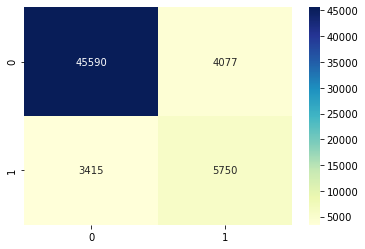

In [40]:
y_train_pred = predict(X_train, mode='best_mode')
metrics(y_train, y_train_pred)

Weighted F1 Score : 0.8746032003246811
MCC Score : 0.5300770552709704


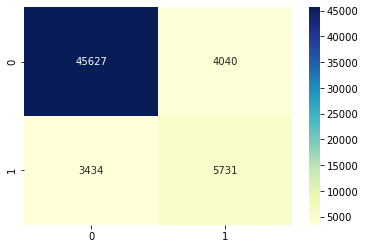

In [41]:
y_train_pred2 = predict(X_train, mode='best_mean')
metrics(y_train, y_train_pred2)

Weighted F1 Score : 0.875222691342712
MCC Score : 0.5305932458396688


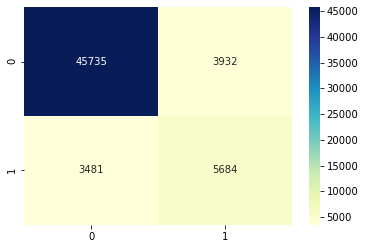

In [42]:
y_train_pred3 = predict(X_train, mode='ensemble_mode')
metrics(y_train, y_train_pred3)

Weighted F1 Score : 0.8753955053400568
MCC Score : 0.5307512464322698


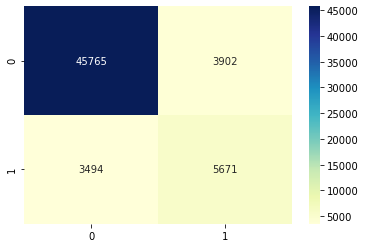

In [43]:
y_train_pred4 = predict(X_train, mode='ensemble_mean')
metrics(y_train, y_train_pred4)

0      0.002322
1      0.002321
2      0.002321
3      0.002321
4      0.002321
         ...   
427    0.002304
428    0.002304
429    0.002304
430    0.002303
431    0.002303
Name: average_mcc, Length: 432, dtype: float64
Weighted F1 Score : 0.8753955053400568
MCC Score : 0.5307512464322698


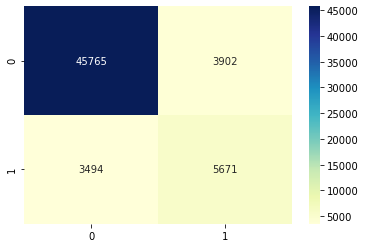

In [44]:
y_train_pred5 = predict(X_train, mode='weighted_ensemble_mean')
metrics(y_train, y_train_pred5)

# Test

In [45]:
y_test_pred = predict(X_test, mode='best_mode')

df_submission = pd.concat([pd.Series(list(range(0, len(X_test))), name='row_id', dtype=np.int32), pd.Series(y_test_pred, name='open_flag')], axis=1)
df_submission.to_csv('submission_best_mode.csv', index=False)

df_submission

,row_id,open_flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
55965,55965,0
55966,55966,0
55967,55967,0
55968,55968,0


In [46]:
y_test_pred2 = predict(X_test, mode='best_mean')

df_submission = pd.concat([pd.Series(list(range(0, len(X_test))), name='row_id', dtype=np.int32), pd.Series(y_test_pred2, name='open_flag')], axis=1)
df_submission.to_csv('submission_best_mean.csv', index=False)

df_submission

,row_id,open_flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
55965,55965,0
55966,55966,0
55967,55967,0
55968,55968,0


In [47]:
y_test_pred3 = predict(X_test, mode='ensemble_mode')

df_submission = pd.concat([pd.Series(list(range(0, len(X_test))), name='row_id', dtype=np.int32), pd.Series(y_test_pred3, name='open_flag')], axis=1)
df_submission.to_csv('submission_ensemble_mode.csv', index=False)

df_submission

,row_id,open_flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
55965,55965,0
55966,55966,0
55967,55967,0
55968,55968,0


In [48]:
y_test_pred4 = predict(X_test, mode='ensemble_mean')

df_submission = pd.concat([pd.Series(list(range(0, len(X_test))), name='row_id', dtype=np.int32), pd.Series(y_test_pred4, name='open_flag')], axis=1)
df_submission.to_csv('submission_ensemble_mean.csv', index=False)

df_submission

,row_id,open_flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
55965,55965,0
55966,55966,0
55967,55967,0
55968,55968,0


In [49]:
y_test_pred5 = predict(X_test, mode='weighted_ensemble_mean')

df_submission = pd.concat([pd.Series(list(range(0, len(X_test))), name='row_id', dtype=np.int32), pd.Series(y_test_pred5, name='open_flag')], axis=1)
df_submission.to_csv('submission_weighted_ensemble_mean.csv', index=False)

df_submission

0      0.002322
1      0.002321
2      0.002321
3      0.002321
4      0.002321
         ...   
427    0.002304
428    0.002304
429    0.002304
430    0.002303
431    0.002303
Name: average_mcc, Length: 432, dtype: float64


,row_id,open_flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
55965,55965,0
55966,55966,0
55967,55967,0
55968,55968,0


# Visualize

* Feature importance
* Tree shape

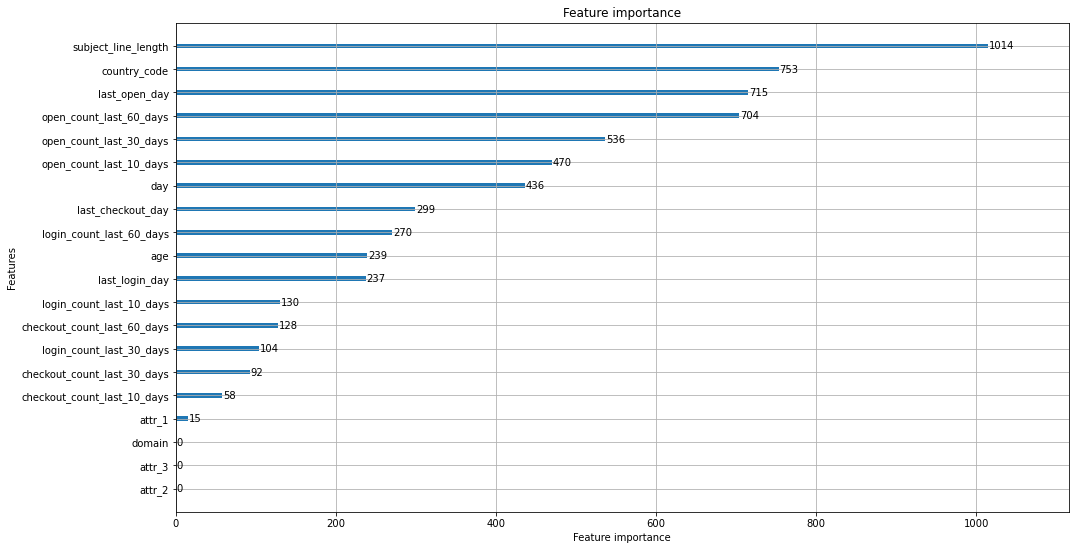

In [50]:
lgbm.plot_importance(df_model.loc[0, 'model_0'], ignore_zero=False, figsize=(16,9))

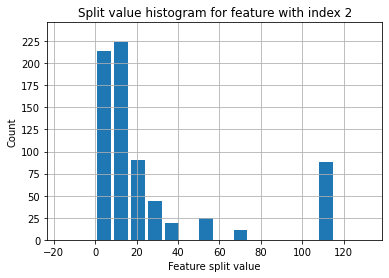

In [51]:
lgbm.plot_split_value_histogram(df_model.loc[0, 'model_0'], 2)